<a href="https://colab.research.google.com/github/Lamaraldeaij/oaqjp-final-project-emb-ai/blob/main/%D9%83%D9%88%D8%AF_%D8%AA%D9%86%D9%82%D9%8A%D8%A8_%D8%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving doc.zip to doc.zip


In [ ]:
import zipfile

with zipfile.ZipFile("doc.zip", "r") as zip_ref:
    zip_ref.extractall("doc")


In [ ]:
path = "/content/doc/doc"

In [ ]:
# Load textual documents from .txt files
import os
import pandas as pd

path = "/content/doc/doc"

documents = []
file_names = []

for filename in os.listdir(path):
    with open(os.path.join(path, filename), "r", encoding="utf-8", errors="ignore") as f:
        documents.append(f.read())
        file_names.append(filename)

df = pd.DataFrame({
    'filename': file_names,
    'text': documents
})
df.head()


,filename,text
0,hospital_doc6.txt,The most incredible experience when it comes t...
1,hospital_doc12.txt,"From customer service to the hospital, doctors..."
2,hospital_doc3.txt,"The staff was so prompt and really sweet, very..."
3,hospital_reviews_15.txt,I dont agree with charging Ill patients with s...
4,2-Coffee Shop de Mathieu.txt,"A highly professional coffee machine, incredi..."


In [ ]:
# Preprocess documents: lowercase, remove punctuation, stopwords
import re
from sklearn.feature_extraction import text

sklearn_stopwords = text.ENGLISH_STOP_WORDS

def simple_preprocess_manual(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in sklearn_stopwords]
    return ' '.join(filtered_tokens)

df['clean_text'] = df['text'].apply(simple_preprocess_manual)
df[['filename', 'clean_text']].head()


,filename,clean_text
0,hospital_doc6.txt,incredible experience comes hospital care minu...
1,hospital_doc12.txt,customer service hospital doctors nurses genui...
2,hospital_doc3.txt,staff prompt really sweet helpful went asthma ...
3,hospital_reviews_15.txt,dont agree charging ill patients high parking ...
4,2-Coffee Shop de Mathieu.txt,highly professional coffee machine incredibly ...


In [ ]:
# Apply TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['clean_text'])

print("TF-IDF matrix shape:", tfidf_matrix.shape)


TF-IDF matrix shape: (30, 1266)


In [ ]:
# Retrieve similar documents using cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

query = "best coffee and friendly staff with good atmosphere"
clean_query = simple_preprocess_manual(query)
query_vector = vectorizer.transform([clean_query])

cos_similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()
top_indices = np.argsort(cos_similarities)[::-1]

retrieval_results = df[['filename']].copy()
retrieval_results['similarity'] = cos_similarities
retrieval_results = retrieval_results.loc[top_indices].reset_index(drop=True)

retrieval_results.head(10)


,filename,similarity
0,3-Bel Horizon Coffee Roasters.txt,0.372440
1,coffee_shop_review3.txt,0.315403
2,2-Coffee Shop de Mathieu.txt,0.306188
3,coffee_shop_reviews_13.txt,0.289122
4,1-Noir - Coffee Shop & Torréfacteur.txt,0.259135
5,5-Café Biboune.txt,0.235292
6,6-Grace Café.txt,0.228700
7,coffee_shop_reviews_15.txt,0.226209
8,coffee_shop_review6.txt,0.213074
9,coffee_shop_review5.txt,0.191627


In [ ]:
# Evaluation: Precision & Recall
relevant_docs = set([
    '3-Bel Horizon Coffee Roasters.txt',
    'coffee_shop_review3.txt',
    '2-Coffee Shop de Mathieu.txt',
    'coffee_shop_reviews_13.txt',
    '1-Noir - Coffee Shop & Torréfacteur.txt',
    'hospital_doc6.txt'
])

retrieved_docs = retrieval_results['filename'][:10].tolist()
true_positives = sum(1 for doc in retrieved_docs if doc in relevant_docs)

precision = true_positives / len(retrieved_docs)
recall = true_positives / len(relevant_docs)

print("Precision:", precision)
print("Recall:", recall)


Precision: 0.5
Recall: 0.8333333333333334


# Classification

# كافيه ومستشفى

In [ ]:

# Step 1: Labeling - Cafe / Hospital
def label_document_cafe_hospital(text):
    text = text.lower()
    if "coffee" in text or "café" in text or "espresso" in text or "barista" in text or "latte" in text:
        return "Cafe"
    elif "hospital" in text or "clinic" in text or "doctor" in text or "nurse" in text or "emergency" in text:
        return "Hospital"
    else:
        return "Unknown"

df['label'] = df['text'].apply(label_document_cafe_hospital)
df[['filename', 'label']].head()

,filename,label
0,hospital_doc6.txt,Hospital
1,hospital_doc12.txt,Hospital
2,hospital_doc3.txt,Hospital
3,hospital_reviews_15.txt,Hospital
4,2-Coffee Shop de Mathieu.txt,Cafe


In [ ]:

# Step 2: Train/Test Split + Naive Bayes Classification
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Filter only known categories
df_filtered = df[df['label'] != "Unknown"]
X = vectorizer.transform(df_filtered['clean_text'])
y = df_filtered['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

        Cafe       0.50      1.00      0.67         1
    Hospital       1.00      0.80      0.89         5

    accuracy                           0.83         6
   macro avg       0.75      0.90      0.78         6
weighted avg       0.92      0.83      0.85         6



In [ ]:
# Optional: Show predictions for test set
df_test = df_filtered.iloc[y_test.index]
df_test['predicted'] = y_pred
df_test[['filename', 'label', 'predicted']]

<ipython-input-25-829694c59992>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predicted'] = y_pred


,filename,label,predicted
27,hospital_doc8.txt,Hospital,Hospital
15,hospital_reviews_13.txt,Hospital,Hospital
23,4-La Maison De L'Indonésie.txt,Cafe,Cafe
17,hospital _ doc9.txt,Hospital,Cafe
8,hospital_doc2.txt,Hospital,Hospital
9,hospital_reviews_14.txt,Hospital,Hospital


# Cluctring

In [ ]:
# Step 1: Clustering using KMeans
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# نستخدم نفس tfidf_matrix
kmeans = KMeans(n_clusters=2, random_state=42)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

df[['filename', 'cluster']].head()

,filename,cluster
0,hospital_doc6.txt,0
1,hospital_doc12.txt,0
2,hospital_doc3.txt,1
3,hospital_reviews_15.txt,1
4,2-Coffee Shop de Mathieu.txt,1


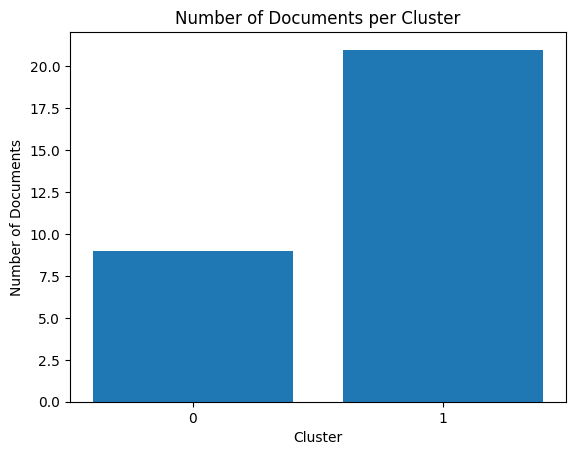

In [ ]:
# Step 2: عرض توزيع المجموعات بالرسم البياني
import numpy as np

cluster_counts = df['cluster'].value_counts().sort_index()
plt.bar(cluster_counts.index.astype(str), cluster_counts.values)
plt.title("Number of Documents per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Documents")
plt.show()

In [ ]:
# Step 3: (اختياري) طباعة الملفات داخل كل Cluster
for cluster_num in sorted(df['cluster'].unique()):
    print(f"\nCluster {cluster_num}:")
    print(df[df['cluster'] == cluster_num]['filename'].tolist())


Cluster 0:
['hospital_doc6.txt', 'hospital_doc12.txt', 'hospital_doc5.txt', 'hospital_doc4.txt', 'hospital_doc2.txt', 'hospital_doc1.txt', 'hospital _ doc9.txt', 'hospital_doc10.txt', 'hospital_doc8.txt']

Cluster 1:
['hospital_doc3.txt', 'hospital_reviews_15.txt', '2-Coffee Shop de Mathieu.txt', 'coffee_shop_review4.txt', 'hospital_reviews_14.txt', '1-Noir - Coffee Shop & Torréfacteur.txt', 'hospital_doc11.txt', 'coffee_shop_review5.txt', 'coffee_shop_reviews_14.txt', 'hospital_reviews_13.txt', 'coffee_shop_reviews_13.txt', '6-Grace Café.txt', 'coffee_shop_review1.txt', 'hospital_doc7.txt', 'coffee_shop_review2.txt', '5-Café Biboune.txt', "4-La Maison De L'Indonésie.txt", 'coffee_shop_review3.txt', 'coffee_shop_review6.txt', '3-Bel Horizon Coffee Roasters.txt', 'coffee_shop_reviews_15.txt']
